In [187]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [188]:
def preprocessing(words):
    unwanted_chars = ['ß', 'à', 'ä', 'ç', 'è', 'é', 'ï', 'ñ', 'ó', 'ö', 'ü', 'ā']

    def contains_unwanted_chars(word):
        return any(char in unwanted_chars for char in word)

    words = [haiku for haiku in words if not any(contains_unwanted_chars(word) for word in haiku)]
    return words

def load_data(path):
    with open(path, 'r') as f:
        words = f.read().splitlines()
    words = preprocessing(words)
    return words

words = load_data('lines.txt')
words = [wr.replace("/", "").replace("$", "") for wr in words]
chars = sorted(list(set(''.join(words)))) #+ ["<S>", "<M>", "<E>"]
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [190]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [3] * block_size
        #print(w)
        # w = w.split("  ")
        # chs = ["<S>"] + list(w[0]) + ["<M>"] + list(w[1])+ ["<M>"] + list(w[2]) + ["<E>"]
        for ch in w + ".": #chs:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(f"'{''.join(itos[i] for i in context)}'", '---->', itos[ix])

            context = context[1:] + [ix]
    
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(43)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([637487, 3]) torch.Size([637487])
torch.Size([79514, 3]) torch.Size([79514])
torch.Size([79753, 3]) torch.Size([79753])


In [191]:
g = torch.Generator().manual_seed(213139812739)

In [192]:
from typing import List
import numpy as np

class Layer():
    def __init__(self, fan_in, fan_out, kaiming=False, activation=F.tanh):
        self.W = torch.randn((fan_in, fan_out), generator=g) * 5/3 / (fan_in ** 0.5)  if kaiming else torch.randn((fan_in, fan_out), generator=g)
        self.b = torch.randn(fan_out, generator=g) * 0

        self.params = [self.W, self.b]
        self.activation_fn = activation

        for param in self.params:
            param.requires_grad = True
    
    def activation(self, x):
        return self.activation_fn(x)
        
    def _f(self, x):
        out = x @ self.W + self.b
        return self.activation(out) if self.activation_fn else out
    
class BatchNorm():
    def __init__(self, fan_in, eps):
        self.bngain = torch.ones((1, fan_in))
        self.bnbias = torch.zeros((1, fan_in))

        self.bnmean_running = torch.zeros((1, fan_in))
        self.bnstd_running = torch.ones((1, fan_in))

        self.params = [self.bngain, self.bnbias]

        self.eps = eps

        for param in self.params:
            param.requires_grad = True

    def _f(self, x, train=True):
        mean = x.mean(0, keepdim=True)
        std = x.std(0, keepdim=True)

        if train:
            x = (x - mean) / (std + self.eps)
            x = x * self.bngain + self.bnbias
            with torch.no_grad():
                self.bnmean_running = 0.999 * self.bnmean_running + 0.001 * mean
                self.bnstd_running = 0.999 * self.bnstd_running + 0.001 * std
        else:
            x = (x - self.bnmean_running) / (self.bnstd_running + self.eps)
            x = x * self.bngain + self.bnbias

        return x

class Sequential():
    def __init__(self, layers: List[Layer]):
        self.layers = layers
        self.params = []
        for layer in self.layers:
            self.params.extend(layer.params)
    
    def forward(self, x, y, lr):
        out = x
        for layer in self.layers:
            out = layer._f(out)
        
        loss = F.cross_entropy(out, y)

        for p in self.params:
            p.grad = None
        
        loss.backward()

        for p in self.params:
            p.data += -lr * p.grad

        return loss

    def predict(self, x):
        with torch.no_grad():
            out = x
            for layer in self.layers:
                if isinstance(layer, BatchNorm):
                    out = layer._f(out, train=False)
                else:
                    out = layer._f(out)
        return out
    
    def display_layer_sizes(self):
        print("Layer Sizes (Top to Bottom):")
        for idx, layer in enumerate(self.layers):
            if isinstance(layer, Layer):
                print(f"Layer {idx + 1}: Input Size = {layer.W.shape[0]}, Output Size = {layer.W.shape[1]}")
            elif isinstance(layer, BatchNorm):
                print(f"Layer {idx + 1}: BatchNorm with Input Size = {layer.bngain.shape[1]}")
            else:
                print(f"Layer {idx + 1}: Unknown Layer Type")

In [193]:
n_embd = 10
block_size = 3
neurons = [128, 64, 32]
embeddings = torch.randn(len(chars), n_embd, generator=g)

layers = [
    Layer(n_embd * block_size, neurons[0], kaiming=True, activation=F.tanh), 
    BatchNorm(neurons[0], 1e-5),
    Layer(neurons[0], neurons[1], kaiming=True, activation=F.tanh), 
    BatchNorm(neurons[1], 1e-5),
    Layer(neurons[1], neurons[2], kaiming=True, activation=F.tanh), 
    BatchNorm(neurons[2], 1e-5),
    Layer(neurons[2], len(chars), activation=None)
]

model = Sequential(layers)

In [194]:
model.display_layer_sizes()

Layer Sizes (Top to Bottom):
Layer 1: Input Size = 30, Output Size = 128
Layer 2: BatchNorm with Input Size = 128
Layer 3: Input Size = 128, Output Size = 64
Layer 4: BatchNorm with Input Size = 64
Layer 5: Input Size = 64, Output Size = 32
Layer 6: BatchNorm with Input Size = 32
Layer 7: Input Size = 32, Output Size = 30


In [195]:
def train_model(
    model: Sequential, 
    num_epochs: int, 
    lr: float = 0.01, 
    verbose: bool = True,
    batch_size: int = 128,
    lr_slow_reduce: bool = False
) -> List[float]:
    losses = []

    for epoch in range(num_epochs):
        if lr_slow_reduce and num_epochs // 2 == epoch:
            lr *= 1e-1
        ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtrain[ix], Ytrain[ix]
        emb = embeddings[Xb]
        emb = emb.view(emb.shape[0], -1)
        loss = model.forward(emb, Yb, lr)
        losses.append(loss.item())

        if verbose and (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} Loss: {loss.item()}")

    return losses

losses = train_model(model, 50000, lr=0.1, lr_slow_reduce=True)  

Epoch 1000/50000 Loss: 2.0362493991851807
Epoch 2000/50000 Loss: 2.1796653270721436
Epoch 3000/50000 Loss: 1.9617687463760376
Epoch 4000/50000 Loss: 2.0681209564208984
Epoch 5000/50000 Loss: 1.8228273391723633
Epoch 6000/50000 Loss: 1.842728614807129
Epoch 7000/50000 Loss: 1.8294458389282227
Epoch 8000/50000 Loss: 1.7653332948684692
Epoch 9000/50000 Loss: 1.8161022663116455
Epoch 10000/50000 Loss: 1.9704763889312744
Epoch 11000/50000 Loss: 1.7892134189605713
Epoch 12000/50000 Loss: 1.9734828472137451
Epoch 13000/50000 Loss: 1.8393536806106567
Epoch 14000/50000 Loss: 2.032301187515259
Epoch 15000/50000 Loss: 1.814119815826416
Epoch 16000/50000 Loss: 1.7743594646453857
Epoch 17000/50000 Loss: 1.8810372352600098
Epoch 18000/50000 Loss: 1.8200656175613403
Epoch 19000/50000 Loss: 1.748762845993042
Epoch 20000/50000 Loss: 2.2886340618133545
Epoch 21000/50000 Loss: 1.86447012424469
Epoch 22000/50000 Loss: 1.8632314205169678
Epoch 23000/50000 Loss: 1.7213225364685059
Epoch 24000/50000 Loss: 1.

Text(0.5, 0, 'Epoch')

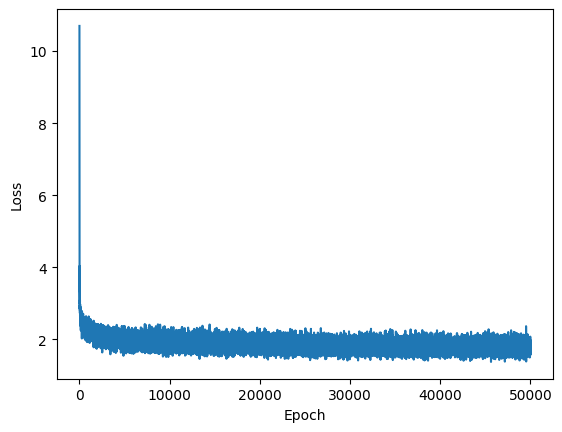

In [196]:
plt.plot(np.arange(len(losses)), losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [198]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = embeddings[x]
    emb = emb.view(emb.shape[0], -1)
    out = model.predict(emb)   
    loss = F.cross_entropy(out, y)

    return loss.item()

In [199]:
split_loss('train'), split_loss('dev'), split_loss('test')

(1.767958641052246, 1.774521827697754, 1.7910852432250977)

### Improvement!!

### Pre weight init optimization -> (1.7559022903442383, 1.7703694105148315, 1.785829782485962)
### Post weight init optimization -> (1.7148950099945068, 1.729537844657898, 1.7452518939971924)
### Post Batch norm -> (1.77047860622406, 1.7761619091033936, 1.7911485433578491)
### Multiple layers with batch norm -> (1.703819990158081, 1.7108787298202515, 17226266860961914) - > BEST RESULT YET!


#### Is this proof that batch norm sucks with lesser layers?

In [204]:
block_size = 3
for _ in range(20):
    res = []

    context = [3] * block_size
    while True:
        emb = embeddings[torch.tensor(context)]
        emb = emb.view(1, -1)
        out = model.predict(emb)

        out = F.softmax(out, dim=-1)
        out = torch.multinomial(out, 1).item()

        if out == 3:
            break

        res.append(out)
        context = context[1:] + [out]
        
    print(''.join(itos[i] for i in res).replace("  ", " ").replace("   ", " "))

i just yark stor rike 
i girled you star sughly  joy  a spater the will yountinus limpremerubender thicert beuling 
you ander sproilenot race our brain for aled 
i oting will retter 
did your refles mentle  you dead 
caugh  it's ces 
rack on thesercomy lia and two fellalife grain prine hunge behaos of taste the some lastweek 
potions ignortinging my words the grow i littlessand an you thour words court drura goodles advhs 
i don't so 
what having left the colold memate a sater or me hopespiries ome 
plled so a takener tearting all of gurklobecake midcrill ring loqke severy nearders all on  cold bird my hear sunnalisplitity cond dolen 
i want 
truth orcaled is shodce the to shink palls some throot res botter ange 
a we them check aretfnilly a spristerian 
eyese we beaches just gent sunser  i deatouaint just apped me cound the sated 
i reterself 
onigitreath your summent me lith 
it shim the pose 
ember you glarach ofn a tr hade you dows tlate a slowinto haiku wolly the skies it a for 
t

/var/folders/np/gp8d_33j4jxd2pd79hf5w03r0000gn/T/ipykernel_7467/1895009486.py:39: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = x.std(0, keepdim=True)
